# Calculating the Voronoi weighted polygon of a district using points from gridded data

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pyproj
import datetime as dt
from scipy.spatial import Voronoi

import matplotlib.pyplot as plt
from functools import partial

from shapely.geometry import Point, shape, Polygon
from shapely import geometry
from shapely.ops import transform

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area,plot_voronoi_polys,plot_points
from geovoronoi import voronoi_regions_from_coords, points_to_coords,points_to_region
from geovoronoi._voronoi import region_polygons_from_voronoi


In [5]:
##############################Read the shape file for the district#############################
#boundary=gpd.read_file("R:\All Shape File\India District\India updated district boundary 2020.shp")
boundary=gpd.read_file("/mnt/r/All Shape File/India District/India updated district boundary 2020.shp")
shp=boundary[boundary.DISTRICT_1 == 'BHOPAL']
lon_min,lat_min,lon_max,lat_max=shp.total_bounds
total_area=(shp['Area(sqm)'])/10**6

In [15]:
######################Read any gridded data of required resolution############################# 
#da=xr.open_dataset('S:/IMD_rainfall_0.25/_Clim_Pred_LRF_New_RF25_IMD0p252020.nc')
da=xr.open_mfdataset('/mnt/rc/IMD_rainfall_0.25/_Clim_Pred_LRF_New_RF25_IMD0p25201*.nc')
da
da_ci=(da.sel(LATITUDE= slice(lat_min,lat_max),LONGITUDE = slice(lon_min,lon_max)))

lat=da_ci.LATITUDE.values
lon=da_ci.LONGITUDE.values
time=da_ci.TIME.values
lats,lons=np.meshgrid(lat,lon)

In [16]:
#########################Create the Voronoi polygon with the coords and shape file################
df = pd.DataFrame({'Latitude' : lats.flatten(), 'Longitude' : lons.flatten()})
gdf=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
gdf
gdf.crs = {'init' :'epsg:3395'}
shp.crs = {'init' :'epsg:3395'}
boundary_shape = shp.geometry.unary_union
coords = points_to_coords(gdf.geometry)
poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)

/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
########################Store the point ID and polygon ID in variables#############################
pts_region=points_to_region(pts)
pts_id=np.empty((6),dtype='int32')
poly_id=np.empty((6),dtype='int32')
i=0
for key, value in pts_region.items():
    pts_id[i]=key
    poly_id[i]=value
    i+=1

pts_region

{1: 0, 2: 1, 0: 2, 4: 3, 3: 4, 5: 5}

In [18]:
####################Attain the coordinates and their associated polygons####################
#####################Calculate the fractional area of each polygon##########################
ndim=2
COORDS=np.empty((len(coords),ndim),dtype='float32')
Area=np.empty(len(coords),dtype='float32')
projected_area=np.empty(len(coords))
fraction_area=np.empty(len(coords))
for i in range(len(coords)):
    k=pts_id[i]
    COORDS[i][0]=coords[k][0]
    COORDS[i][1]=coords[k][1]
for j in range(len(coords)):
    #k=poly_id[j]
    #Area[j]=poly_shapes[k].area
    s = shape(poly_shapes[j])
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)
    projected_area[j] = (transform(proj, s).area)/10**6
    fraction_area[j]=projected_area[j]/total_area
    del s
    del proj
    del s_new

/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is

In [19]:
###########################Store all the IDs, coordinates and fractional area in a dataframe################
fract_area=pd.DataFrame()
fract_area['Point_ID']=pts_id
fract_area['Poly_ID']=poly_id
fract_area['Point_Lon']=COORDS[:,0]
fract_area['Point_Lat']=COORDS[:,1]
fract_area['Poly_area_km2']=projected_area
fract_area['fraction']=fraction_area
fract_area

,Point_ID,Poly_ID,Point_Lon,Point_Lat,Poly_area_km2,fraction
0,1,0,77.25,23.50,332.971607,0.109883
1,2,1,77.25,23.75,608.526815,0.200817
2,0,2,77.25,23.25,606.083001,0.200011
3,4,3,77.50,23.50,492.595086,0.162559
4,3,4,77.50,23.25,768.059123,0.253464
5,5,5,77.50,23.75,495.361942,0.163472


In [20]:
##########################Obtain the district rainfall time series using info from above dataframe###############
rain=da.RAINFALL
rain
accum_rf=np.full((len(time)),fill_value=0.0)
for j in range (len(time)):
    for i in range(len(coords)):
        ind_lat=coords[i,1]
        ind_lon=coords[i,0]
        rain_p=rain.sel(TIME=time[j],LATITUDE=ind_lat,LONGITUDE = ind_lon).values
        area_p=fract_area.fraction[fract_area.Point_ID == i].values
        accum_rf[j]=accum_rf[j]+rain_p*area_p
        del rain_p
        del area_p

accum_rf

array([0., 0., 0., ..., 0., 0., 0.])

/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


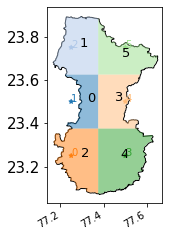

In [21]:
###########################Plotting the Voronoi polygon and the coordinates########################################
fig, ax = subplot_for_map(show_x_axis=True,show_y_axis=True)
#plot_voronoi_polys(ax, region_polys, color=None, edgecolor=None, labels=None, label_fontsize=10, label_color=None, **kwargs)
#plot_voronoi_polys(ax, poly,color=['red','blue','green','yellow'],edgecolor='black')
#plot_points(ax,coords,color='black')
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, coords, 
                                    pts, voronoi_and_points_cmap='tab20', points_markersize=20, points_marker='*',point_labels=[0,1,2,3,4,5],
                                    point_label_fontsize=10,voronoi_labels=list(poly_id),voronoi_label_fontsize=13, voronoi_label_color='black',
                                    points_color='black')
plt.show()

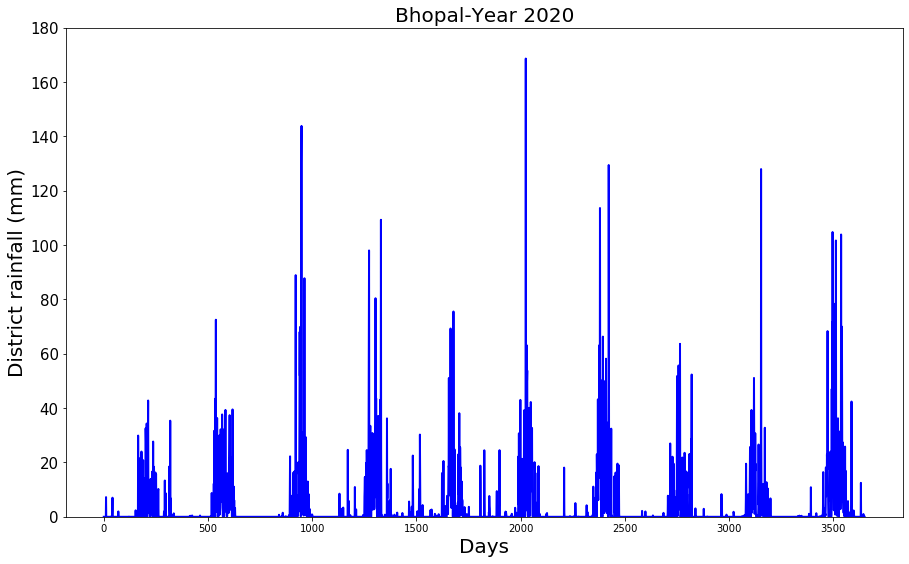

In [29]:
################################Plotting the time series for a district#############################
Time=da_ci['TIME'].dt.strftime('%m/%d/%Y')
x=range(len(time))

fig=plt.figure(figsize=(15,9))
plt.plot(x,accum_rf,linewidth=2.0,linestyle='-',color='b')	# marker='o'
#plt.axhline(y=0.0, color='red', linestyle='--')
plt.xlabel('Days')
plt.ylim(0,180)
#plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=15)
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) # Axes title
plt.ylabel('District rainfall (mm)')
plt.title('Bhopal-Year 2020')
#plt.xticks(x,Time.values,rotation=60)
plt.savefig('Voronoi_weighted_rainfall_bhopal_time_series.png')

In [23]:
len(time)

3652

In [27]:
DF = pd.DataFrame()
DF['DATE']=time
DF['District_rainfall_mm']=accum_rf
DF.to_csv("Bhopal_voronoi_rf.csv")